# Baseline Code

This code introduces a two-step training for the N-HPatches problem. In N-HPatches problem, we aim to generate a patch descriptor that is able to perform successfully tasks such as matching, retrieval or verification. 

Contrary to classical HPatches dataset, in N-HPatches, images contain random non-smooth perturbations produced by a synthetic noise. This noise could be critical when training the descriptor, therefore, we introduce a denoising model that could help us to deal with those perturbations. Denoising models have been already introduced in the course [tutorials](https://github.com/MatchLab-Imperial/deep-learning-course) and lectures, their objective is to generate a clean/denoised version of the input image.  We will refer in this code to the images with noise as `noisy`, to the images after applying the denoise model as `denoised` and the original patches from HPatches (so no extra noise added) which are used as ground-truth for the denoising step as `clean`. 


Thus, we aim to minimize the noise in images before the second step, which is computing a feature vector, also called descriptor. Those descriptions must be a powerful representation of the input patches. The idea behind is that if two descriptors belong two similar patches, they should be close to each other, i.e. have a low Euclidean distance. See figure below:

![](https://i.ibb.co/4tvm3Vh/descriptorspace.png)

This baseline code gives a method you can use to compare to whatever another approach you develop.  There are several other approaches you can test to see if there is any improvement, e.g. train the descriptor directly with noisy patches, without the denoising model. However, this code provides some guidance about how to implement the different blocks, how to stack them if desired, how to read the data and how to evaluate the method.

The values given can be improved without changing the core method, only by tuning correctly the hyperparameters or giving it more training time, among others.

As a first step of the project, you should get familiar with the problem and the provided code, so you can develop more complex and robust algorithms afterward. 

## Safety Check

As Google Colab is an external platform, we cannot guarantee that everytime you connect to a remote server, you will have the same amount of RAM or video RAM. For that reason, we will first check the amount of memory we have in the notebook. RAM should be around 12.9 GB, which is enough to load the datasets in memory. Also, usually, we have available 11.4 GB of GPU memory, which is more than enough to run this code. However, some users reported having only 500 MB of GPU memory. If you have that amount, restart the environment to see if you get the corresponding 11.4 GB.

In [0]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
printm()

('RAM Free: 12.9 GB', ' | Proc size: 152.0 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Downloading Functions and Data

The first step is to clone the GitHub repository of the course, which contains already implemented functions. You can use your own function and import them here doing the same. In addition, we are going to download and extract the N-HPatches data. 

As a note, in colab, we can run terminal commands by using ```!```. Also, by using ```%``` we have access to the [built-in IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd), which we will use to move through directories (`cd` command). It takes around 5 minutes to download and unzip the dataset. 


In [0]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

Cloning into 'keras_triplet_descriptor'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 181 (delta 0), reused 1 (delta 0), pack-reused 178
Receiving objects: 100% (181/181), 149.87 MiB | 19.26 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Checking out files: 100% (69/69), done.


In [0]:
# Change directory
%cd /content/keras_triplet_descriptor    


/content/keras_triplet_descriptor


In [0]:
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


--2019-03-21 10:02:11--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 185.235.236.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-21 10:02:12--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-21 10:02:12--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.bo

In [0]:
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [0]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.model_selection import GridSearchCV


from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


The `read_data` and `utils` imports are functions provided in the repository we just cloned. You can navigate through the *File tab* and check what those functions do for a better understanding.

![texto del enlace](https://i.ibb.co/HnfSvfT/filetab.png)





We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [0]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

#we train on the a split of HPatches are specified in the repository
splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


In [0]:
#Establishing size of sequences
len(seqs_train)
len(seqs_test)

## Models and loss

In [0]:
# This is the implementation of DeepUNet with modifications to some hyperparameters
# he uniform was better performing than glorot_uniform 

def get_denoise_model(shape):
  
    inputs = Input(shape)
    
    conv1 = Conv2D(16, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block1_conv1')(inputs)
    
    conv1 = Conv2D(16, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block1_conv2')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(32, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block2_conv1')(pool1)
    
    conv2 = Conv2D(32, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block2_conv2')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(64, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block3_conv1')(pool2)
    
    conv3 = Conv2D(64, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block3_conv2')(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block4_conv1')(pool3)
    
    conv4 = Conv2D(128, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block4_conv2')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block5_conv1')(pool4)
    
    conv5 = Conv2D(128, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block5_conv2')(conv5)
    
    up1 = UpSampling2D(size = (2,2))(conv5)
    
    merge1 = concatenate([conv4,up1])
    
    conv6 = Conv2D(128, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block6_conv1')(merge1)
    
    conv6 = Conv2D(64, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block6_conv2')(conv6)
    
    up2 = UpSampling2D(size = (2,2))(conv6)
    
    merge2 = concatenate([conv3,up2])

    conv7 = Conv2D(64, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block7_conv1')(merge2)
    
    conv7 = Conv2D(32, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block7_conv2')(conv7)
    
    up3 = UpSampling2D(size = (2,2))(conv7)
    
    merge3 = concatenate([conv2,up3])

    conv8 = Conv2D(32, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block8_conv1')(merge3)
    
    conv8 = Conv2D(16, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block8_conv2')(conv8)
    
    up4 = UpSampling2D(size = (2,2))(conv8)
    
    merge4 = concatenate([conv1,up4])

    conv9 = Conv2D(16, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block9_conv1')(merge4)
    
    conv9 = Conv2D(32, (3, 3), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block9_conv2')(conv9)

    model_output = Conv2D(1, (1, 1), 
               use_bias=False, padding="same",activation="relu",
               strides=1,kernel_initializer='he_uniform',
               name='block9_conv3')(conv9)

    deep_unet = Model(inputs = inputs, outputs = model_output)
  
    return deep_unet

 

In [0]:
shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)

In [0]:
denoise_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 32, 32, 16)   144         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 32, 32, 16)   2304        block1_conv1[0][0]               
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 16, 16, 16)   0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [0]:
def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model
  
  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MAE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

In [0]:
# This is the sample sizing for monitoring and adjusting an unoptimised model
#denoise_generator = DenoiseHPatches(random.sample(seqs_train, 8), batch_size=32)
#denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 2), batch_size=32)

# This is the 'whole' training set for upgraded model due to colab GPU constraints
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 28), batch_size=32)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 7), batch_size=32)

# Uncomment following lines for using all the data to train the denoising model
# Only used for baseline model
#denoise_generator = DenoiseHPatches(seqs_train, batch_size=32)
#denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=32)

100%|██████████| 7/7 [00:08<00:00,  1.03s/it]


We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model.

In [0]:
#sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)

# New optimiser and learning rate decreased by a factor of 10
Adam = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

denoise_model.compile(loss='mean_absolute_error', optimizer=Adam, metrics=['mae', 'acc'])

# Reload the model to train since it keeps disconnecting rip
# denoise_model.set_weights(keras.models.load_model('./upgraded_denoise.h5').get_weights())
# denoise_model.optimizer = keras.models.load_model('./upgraded_denoise.h5').optimizer

#denoise_model = keras.models.load_model('./upgraded_denoise.h5')

#Patience set to 8 due to length of time required for whole dataset epoch runs. Usually value would be 10-20.  
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

epochs = 30

### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

for e in range(epochs):
  denoise_history = denoise_model.fit_generator(generator=denoise_generator, 
                                                epochs=1, verbose=1, 
                                                validation_data=denoise_generator_val)
  ### Saves optimizer and weights
  denoise_model.save('upgraded_denoise.h5') 
  ### Uploads files to external hosting
  #!curl -F "file=@denoise.h5" https://file.io

Epoch 1/1
16831/16831 [==============================] - 595s 35ms/step - loss: 9.5480 - mean_absolute_error: 9.5480 - acc: 0.0479 - val_loss: 6.6565 - val_mean_absolute_error: 6.6565 - val_acc: 0.0591
Epoch 1/1
16831/16831 [==============================] - 594s 35ms/step - loss: 6.7664 - mean_absolute_error: 6.7664 - acc: 0.0611 - val_loss: 6.0761 - val_mean_absolute_error: 6.0761 - val_acc: 0.0659
Epoch 1/1
16831/16831 [==============================] - 582s 35ms/step - loss: 6.2687 - mean_absolute_error: 6.2687 - acc: 0.0683 - val_loss: 5.6966 - val_mean_absolute_error: 5.6966 - val_acc: 0.0749
Epoch 1/1
16831/16831 [==============================] - 566s 34ms/step - loss: 6.0309 - mean_absolute_error: 6.0309 - acc: 0.0735 - val_loss: 5.5564 - val_mean_absolute_error: 5.5564 - val_acc: 0.0777
Epoch 1/1
16831/16831 [==============================] - 570s 34ms/step - loss: 5.8948 - mean_absolute_error: 5.8948 - acc: 0.0764 - val_loss: 5.4393 - val_mean_absolute_error: 5.4393 - val_ac

In [0]:
# Hardly used due to the fact that we saved each epoch individually in case GPU disconnected

import matplotlib.pyplot as plt

def plot_history(history, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1)
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Train', 'Val'])
    except:
      pass
    axes[0].set_title('{:s}'.format(metric))
    axes[0].set_ylabel('{:s}'.format(metric))
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Train', 'Val'])
    except:
      pass
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')

    
#Only runs when epochs are specified in the loop but chose to specify outside incase of collab quitting so that weights were saved in h5 files. 
plot_history(denoise_history)

In [0]:
# Make sure file is in keras_descriptor folder!
#For loading previous weights
#denoise_model = keras.models.load_model('./denoise.h5')

### Visualization of Denoising Results
To visualize how the denoised patches look, you can run the following function. It returns the noisy patch, the denoised patch in the middle, and the clean patch in the right side. 

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


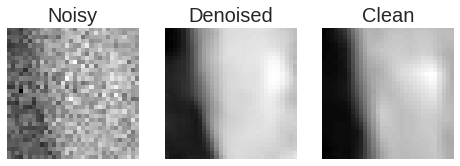

In [0]:
plot_denoise(denoise_model)

## Training a Descriptor Network
In the last section we trained a model that given a noisy patch, outputs a denoised version of it. We hoped that by doing so, we will improve the performance of the second part, which is training a network that outputs the descriptor. As we mentioned, a descriptor is a numerical vector that represents the small images we have. The dataset consists of a large number of small images, which are cropped patches from other larger images. Hence, they represent some local part of a scene. That is why there are no objects represented, only corners or textures. Each of these patches is related to a subset of other patches of the dataset by some kind of geometric transformation (e.g. rotation).  For a given patch, we want the network to output a vector that is close to the vectors of the patches that represent the same local part of a scene, while being far from patches do not represent that local part of a scene.

To do so, we will build a convolutional neural network that takes the input of $32\times32$ and outputs a descriptor of size $128$. For the loss, we use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

**Updated explanation**: Due to the way Keras handles the compile method, it needs a loss as an argument in that compile method. However, our loss is computed in the lambda layer, so we want to minimize the output of that layer. As we want to minimize the output of the Lambda function (in this case the triplet loss), we output as the label in the training_generator a vector of zeros and we compute the mean absolute error of the triplet loss and this vector of zeros. To give you an intuition, what we aim to minimize is
$$  |\text{triplet_loss} - 0| =  |\text{triplet_loss}| = \text{triplet_loss} $$



In [0]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)

#lr decreased by 10, added Nesterov default momentum 
#sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['acc'])

In [0]:
descriptor_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        18496     
__________

Here we use the class HPatches, which loads the corresponding files by using the method `read_image_file`. It reads the patches. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class `DataGeneratorDesc`. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

**Updated**: In the previous version of the baseline code, we were training the descriptor model with the noisy patches, not with the denoised ones. By adding the argument `denoise_model=denoise_model` to the class HPatches we can use the denoised images instead to train this descriptor model (if `denoise_model=None`, the noisy patches will be used). However, as it has to compute the denoised patch first, the loading of the data will be slower (6/7 extra min).  If you want to train the model with the clean patches instead, you can set the argument `use_clean=True`. In this last case, even if a denoise model is given, it will not be used. When running this piece of code **the type of patches (denoised, noisy or clean) used is printed**.

In [0]:
from keras.models import load_model

denoise_model = get_denoise_model('./denoise.h5')

In [0]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model, use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=120000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=30000)


Using denoised patches
100%|██████████| 116/116 [00:36<00:00,  3.13it/s]
Denoising patches...
100%|██████████| 15589/15589 [06:43<00:00, 38.65it/s]


100%|██████████| 120000/120000 [00:02<00:00, 54388.96it/s]


Using denoised patches
100%|██████████| 116/116 [00:21<00:00,  5.29it/s]
Denoising patches...
100%|██████████| 9525/9525 [04:04<00:00, 38.90it/s]


100%|██████████| 30000/30000 [00:00<00:00, 81496.71it/s]


We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

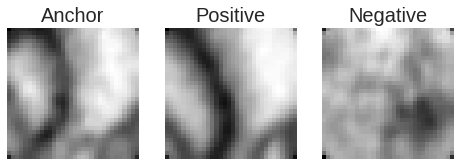

In [0]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [0]:
epochs = 30
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

for e in range(epochs):
  
  descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  
  ### Saves optimizer and weights
  descriptor_model_trip.save('descriptor.h5') 
  ### Uploads files to external hosting
  #!curl -F "file=@descriptor.h5" https://file.io


Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.1982 - acc: 0.8799

100%|██████████| 120000/120000 [00:05<00:00, 22440.33it/s]


2400/2400 [==============================] - 210s 87ms/step - loss: 0.1982 - acc: 0.8799 - val_loss: 0.1948 - val_acc: 0.8910
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.1486 - acc: 0.9100

100%|██████████| 120000/120000 [00:04<00:00, 27537.33it/s]


2400/2400 [==============================] - 204s 85ms/step - loss: 0.1486 - acc: 0.9100 - val_loss: 0.1902 - val_acc: 0.8783
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.1319 - acc: 0.9197

100%|██████████| 120000/120000 [00:05<00:00, 22296.15it/s]


2400/2400 [==============================] - 205s 85ms/step - loss: 0.1319 - acc: 0.9197 - val_loss: 0.1585 - val_acc: 0.9027
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.1215 - acc: 0.9255

100%|██████████| 120000/120000 [00:04<00:00, 26317.21it/s]


2400/2400 [==============================] - 204s 85ms/step - loss: 0.1215 - acc: 0.9255 - val_loss: 0.1747 - val_acc: 0.8904
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.1183 - acc: 0.9265

100%|██████████| 120000/120000 [00:04<00:00, 26639.38it/s]


2400/2400 [==============================] - 204s 85ms/step - loss: 0.1182 - acc: 0.9264 - val_loss: 0.1543 - val_acc: 0.9057
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.1108 - acc: 0.9315

100%|██████████| 120000/120000 [00:04<00:00, 27554.99it/s]


2400/2400 [==============================] - 205s 85ms/step - loss: 0.1108 - acc: 0.9315 - val_loss: 0.1630 - val_acc: 0.8975
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.1076 - acc: 0.9329

100%|██████████| 120000/120000 [00:04<00:00, 26970.29it/s]


2400/2400 [==============================] - 204s 85ms/step - loss: 0.1076 - acc: 0.9329 - val_loss: 0.1356 - val_acc: 0.9177
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.1052 - acc: 0.9344

100%|██████████| 120000/120000 [00:04<00:00, 27215.73it/s]


2400/2400 [==============================] - 205s 85ms/step - loss: 0.1053 - acc: 0.9344 - val_loss: 0.1399 - val_acc: 0.9132
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.1008 - acc: 0.9373

100%|██████████| 120000/120000 [00:04<00:00, 26624.70it/s]


2400/2400 [==============================] - 205s 86ms/step - loss: 0.1008 - acc: 0.9373 - val_loss: 0.1297 - val_acc: 0.9204
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.1005 - acc: 0.9366

100%|██████████| 120000/120000 [00:04<00:00, 27315.12it/s]


2400/2400 [==============================] - 205s 86ms/step - loss: 0.1005 - acc: 0.9366 - val_loss: 0.1262 - val_acc: 0.9196
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0974 - acc: 0.9383

100%|██████████| 120000/120000 [00:04<00:00, 26044.32it/s]


2400/2400 [==============================] - 205s 85ms/step - loss: 0.0974 - acc: 0.9383 - val_loss: 0.1350 - val_acc: 0.9181
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0961 - acc: 0.9394

100%|██████████| 120000/120000 [00:04<00:00, 26126.88it/s]


2400/2400 [==============================] - 205s 85ms/step - loss: 0.0961 - acc: 0.9394 - val_loss: 0.1313 - val_acc: 0.9180
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0939 - acc: 0.9417

100%|██████████| 120000/120000 [00:04<00:00, 26609.80it/s]


2400/2400 [==============================] - 204s 85ms/step - loss: 0.0939 - acc: 0.9417 - val_loss: 0.1454 - val_acc: 0.9134
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0933 - acc: 0.9408

100%|██████████| 120000/120000 [00:04<00:00, 26937.31it/s]


2400/2400 [==============================] - 205s 85ms/step - loss: 0.0933 - acc: 0.9407 - val_loss: 0.1234 - val_acc: 0.9252
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0912 - acc: 0.9424

100%|██████████| 120000/120000 [00:04<00:00, 26953.66it/s]


2400/2400 [==============================] - 204s 85ms/step - loss: 0.0912 - acc: 0.9424 - val_loss: 0.1364 - val_acc: 0.9157
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0906 - acc: 0.9428

100%|██████████| 120000/120000 [00:04<00:00, 26685.10it/s]


2400/2400 [==============================] - 205s 85ms/step - loss: 0.0906 - acc: 0.9427 - val_loss: 0.1700 - val_acc: 0.8914
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0882 - acc: 0.9446

100%|██████████| 120000/120000 [00:04<00:00, 25858.85it/s]


2400/2400 [==============================] - 204s 85ms/step - loss: 0.0882 - acc: 0.9446 - val_loss: 0.1349 - val_acc: 0.9167
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0897 - acc: 0.9433

100%|██████████| 120000/120000 [00:04<00:00, 25818.83it/s]


2400/2400 [==============================] - 209s 87ms/step - loss: 0.0897 - acc: 0.9433 - val_loss: 0.1474 - val_acc: 0.9116
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0862 - acc: 0.9455

100%|██████████| 120000/120000 [00:04<00:00, 25825.25it/s]


2400/2400 [==============================] - 206s 86ms/step - loss: 0.0861 - acc: 0.9455 - val_loss: 0.1169 - val_acc: 0.9286
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0819 - acc: 0.9476

100%|██████████| 120000/120000 [00:05<00:00, 23088.70it/s]


2400/2400 [==============================] - 207s 86ms/step - loss: 0.0819 - acc: 0.9476 - val_loss: 0.1410 - val_acc: 0.9172
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0817 - acc: 0.9476

100%|██████████| 120000/120000 [00:04<00:00, 26212.08it/s]


2400/2400 [==============================] - 206s 86ms/step - loss: 0.0816 - acc: 0.9476 - val_loss: 0.1206 - val_acc: 0.9253
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0831 - acc: 0.9469

100%|██████████| 120000/120000 [00:05<00:00, 23089.48it/s]


2400/2400 [==============================] - 208s 87ms/step - loss: 0.0831 - acc: 0.9469 - val_loss: 0.1354 - val_acc: 0.9194
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0803 - acc: 0.9481

100%|██████████| 120000/120000 [00:04<00:00, 26262.30it/s]


2400/2400 [==============================] - 207s 86ms/step - loss: 0.0803 - acc: 0.9481 - val_loss: 0.1129 - val_acc: 0.9265
Epoch 1/1
2399/2400 [============================>.] - ETA: 0s - loss: 0.0770 - acc: 0.9505

100%|██████████| 120000/120000 [00:05<00:00, 22530.22it/s]


2400/2400 [==============================] - 208s 86ms/step - loss: 0.0770 - acc: 0.9505 - val_loss: 0.1123 - val_acc: 0.9286
Epoch 1/1
 561/2400 [======>.......................] - ETA: 2:26 - loss: 0.0752 - acc: 0.9517Buffered data was truncated after reaching the output size limit.

## Generating descriptors files for test data 

To evaluate the performance of out model we will use an existing evaluation code, which is called HPatches benchmark. HPatches benchmark takes as input the descriptors for the test data in a CSV form. So the whole pipeline is represented in the following image.

![](https://i.ibb.co/WcDDf3q/Screenshot-from-2019-02-15-11-17-24.png)

This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to `None`), the descriptor is computed directly in the noisy patch.

Similarly to the loading data part, you have the denoise_model variable and `use_clean` variable. If `use_clean` is set to True, the CSV generated will be those of the clean patches, even if a denoising model is given. If set to False, then depends on the variable `denoise_model`. If there is no denoise model (`denoise_model=None`), then it will use the noisy patches. If you give a denoising model, then it will compute the CSV for the denoised patches. This can be useful to explore different scenarios (for example, the Upper Bound can be training the descriptor network with clean patches, and testing with clean patches), however you should always report the score when using noisy patches (depending on the approach you develop, you may want to denoise them or not). The official baseline uses the denoised patches. 

In [0]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model, use_clean=False)

100%|██████████| 40/40 [08:02<00:00, 11.27s/it]


## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

**Updated**: The necessary code is included in the repository we cloned at the beginning of the code, so we do not need to download any extra data. Also, we simplified the results, so now they only return one value for each of the three tasks.

Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script. The scripts will return a score for each of the tasks. The metric used is called mean Average Precision, which it uses the Precision of the model. The Precision is defined, for a given number of retrieved elements, as the ratio of correct retrieved elements / number of retrieved elements. [Link to Wikipedia with Precision explanation](https://en.wikipedia.org/wiki/Precision_and_recall). The definition of the three different tasks is taken from the [HPatches paper](https://arxiv.org/pdf/1704.05939.pdf).

In all of the tasks if you use the optional argument `--more_info` in `hpatches_results.py` you can see extra mAP information. However, the important score is the mAP score reported without this flag.

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:25<00:00, 11654.78it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:25<00:00, 11674.54it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:26<00:00, 11600.46it/s]
>> Verification task finished in 266 secs  
Verification task results:
Mean Average Precision is 0.806913




### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:11<00:00,  4.45s/it]
>> Matching task finished in 131 secs  
Matching task results:
Mean Average Precision is 0.217416






### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc 1600004096 bytes == 0x55c1d8e4c000 @  0x7f4a30c0a1e7 0x7f4a2680bcf1 0x7f4a2686e3a2 0x7f4a268700de 0x7f4a269070e8 0x55c1b0abdfe5 0x55c1b0ab3d0a 0x55c1b0abb5fe 0x55c1b0abb232 0x55c1b0ab3d0a 0x55c1b0abbc38 0x55c1b0ab3d0a 0x55c1b0ab3629 0x55c1b0ae461f 0x55c1b0adf322 0x55c1b0ade67d 0x55c1b0a8d1ab 0x7f4a30807b97 0x55c1b0a8ca2a
>> Distance matrix done.
Processing retrieval task: 100% 10000/10000 [03:53<00:00, 42.85it/s]
>> Retrieval task finished in 252 secs  
Retrieval task results:
Mean Average Precision is 0.523319


